# Benthic Data

This notebook contains the code used to pull together raw exported CMC and CBP benthic data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## CMC Benthic Data

In [2]:
# reading in CMC benthic data for each state: Jan 1, 1990 - July 11, 2020
benthic_dc = pd.read_csv('./Data/CMC_benthic/benthic_DC.csv', low_memory = False)
benthic_md = pd.read_csv('./Data/CMC_benthic/benthic_MD.csv', low_memory = False)
benthic_pa = pd.read_csv('./Data/CMC_benthic/benthic_PA.csv', low_memory = False)
benthic_va = pd.read_csv('./Data/CMC_benthic/benthic_VA.csv', low_memory = False)

# adding in state
benthic_dc['state'] = 'DC'
benthic_md['state'] = 'MD'
benthic_pa['state'] = 'PA'
benthic_va['state'] = 'VA'

# check shapes
print("DC: ", benthic_dc.shape)
print("MD: ", benthic_md.shape)
print("PA: ", benthic_pa.shape)
print("VA: ", benthic_va.shape)

# calculating total expected rows
total = benthic_dc.shape[0] + \
        benthic_md.shape[0] + \
        benthic_pa.shape[0] + \
        benthic_va.shape[0]
print("Expected Total Rows: ", total)

DC:  (2010, 51)
MD:  (24658, 54)
PA:  (60, 53)
VA:  (14705, 78)
Expected Total Rows:  41433


In [3]:
# combine into one
benthic = pd.concat([benthic_dc, benthic_md, benthic_pa, benthic_va], axis = 0, sort = True)
print("Total DF Shape: ", benthic.shape) # checking shape of combined df

Total DF Shape:  (41433, 79)


In [4]:
# checking if there are duplicate rows, shouldn't be
benthic.drop_duplicates().shape

(41433, 79)

In [5]:
benthic['Database'] = 'CMC'

In [6]:
benthic.head()

,Active Construction,Algae Color,Algae Located,Aquatic Veg/Decaying Matter,Area 1 Sampled,Area 2 Sampled,Area 3 Sampled,Area 4 Sampled,Barriers To Fish Movement,Benthic Classification Code,Benthic Classification Name,Bottom Type,Channel Width,Collection Time (Net 1),Collection Time (Net 2),Collection Time (Net 3),Collection Time (Net 4),Comments,Count,Cropland,Date,DateTime,Define Other Bank Composition,Define Other Land Use,Define Other Organism,Describe the Amount and Type of Litter,Discharge Pipes,Fields,Fish Water Quality Indicators,Forest,GroupName,Housing Development,Indicate Current and Potential Threats,Latitude,Livestock Pasture,Logging,Longitude,Mining,Number of Discharge Pipes,Number of Squirts,Odor,Oil and Gas Drilling,Other Land Use,Percent Algae,Percent Bare Soil,Percent Boulders,Percent Cobbles,Percent Grass,Percent Gravel,Percent Other,Percent Rocks,Percent Sand,Percent Shrubs,Percent Silt,Percent Trees,Precipitation,Sanitary Landfill,Silt/Sand/Gravel,Snags/Logs,Snags/Logs Jabs,Stability of Stream,StationCode,StationName,Stream Bed Deposit,Stream Channel Erosion,Stream Channel Shade,Stream Flow,Surface Water Appearance,Time,Trash Dump,Type of Cropland,Type of Mining,Type of Pipes,Urban Uses,Vegetated,Vegetated Jabs,Weather Conditions,Weather Last 72 Hours,state,Database
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LUMBRICULIDAE,LUMBRICULIDAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,01/06/2001,2001-01-06T12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Audubon Naturalist Society,NaN,NaN,38.971944,NaN,NaN,-77.044167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ANS.Site 23, Pinehurst Branch","Site 23, Pinehurst Branch",NaN,NaN,NaN,NaN,NaN,12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC,CMC
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIPULIDAE,TIPULIDAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,01/06/2001,2001-01-06T12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Audubon Naturalist Society,NaN,NaN,38.971944,NaN,NaN,-77.044167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ANS.Site 23, Pinehurst Branch","Site 23, Pinehurst Branch",NaN,NaN,NaN,NaN,NaN,12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC,CMC
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHIRONOMIDAE,CHIRONOMIDAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,01/06/2001,2001-01-06T12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Audubon Naturalist Society,NaN,NaN,38.971944,NaN,NaN,-77.044167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ANS.Site 23, Pinehurst Branch","Site 23, Pinehurst Branch",NaN,NaN,NaN,NaN,NaN,12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC,CMC
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HYDROPSYCHIDAE,HYDROPSYCHIDAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,NaN,01/06/2001,2001-01-06T12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Audubon Naturalist Society,NaN,NaN,38.971944,NaN,NaN,-77.044167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ANS.Site 23, Pinehurst Branch","Site 23, Pinehurst Branch",NaN,NaN,NaN,NaN,NaN,12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC,CMC
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASELLIDAE,ASELLIDAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,01/06/2006,2006-01-06T12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Audubon Naturalist Society,NaN,NaN,38.938253,NaN,NaN,-77.052642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ANS.Site 31, Hazen Run","Site 31, Hazen Run",NaN,NaN,NaN,NaN,NaN,12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DC,CMC


## CBP Benthic Data

In [7]:
cbp_benthic = pd.read_csv('./Data/CBP_benthic/LivingResourcesTaxonomicHUC12.csv')
cbp_events = pd.read_csv('./Data/CBP_benthic/LivingResourcesMonitorEventHUC12.csv')
cbp_habitat = pd.read_csv('./Data/CBP_benthic/LivingResourcesHabitatHUC12.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
cbp_benthic.rename(columns = {'LatinName': 'Benthic Classification Name'}, inplace = True)

In [9]:
latmap = dict(zip(cbp_events['Station'], cbp_events['Latitude']))
lonmap = dict(zip(cbp_events['Station'], cbp_events['Longitude']))

In [10]:
cbp_benthic['Latitude'] = cbp_benthic['Station'].map(latmap)
cbp_benthic['Longitude'] = cbp_benthic['Station'].map(lonmap)

In [11]:
cbp_benthic['ReportingParmeter'].unique() 

array(['COUNT', nan], dtype=object)

In [12]:
cbp_benthic['Database'] = 'CBP'

## Join CMC & CBP

In [13]:
cbp_benthic.rename(columns = {'SampleTime': 'Time',
                             'SampleDate': 'Date',
                             'ReportingParmeter': 'Count'}, inplace = True)
benthic.rename(columns = {'state': 'State'}, inplace = True)

In [14]:
common = [i for i in benthic.columns if i in cbp_benthic.columns]
cmc_only = [i for i in benthic.columns if i not in common]
cbp_only = [i for i in cbp_benthic.columns if i not in common]

In [15]:
common

['Benthic Classification Name',
 'Count',
 'Date',
 'Latitude',
 'Longitude',
 'Time',
 'State',
 'Database']

In [16]:
allbenthic = pd.concat([benthic, cbp_benthic], axis = 0, sort = True)
allbenthic.shape

(171105, 98)

In [17]:
allbenthic['Benthic Classification Name'].value_counts()

Chironomidae                                   4567
Cheumatopsyche                                 2635
Hydropsychidae                                 2215
HYDROPSYCHIDAE                                 1994
Elmidae                                        1950
Ephemerella                                    1926
Heptageniidae                                  1893
Optioservus                                    1841
CHIRONOMIDAE                                   1747
Stenelmis                                      1699
Baetis                                         1678
Baetidae                                       1596
Simulium                                       1522
Simuliidae                                     1485
Hydropsyche                                    1454
Amphinemura                                    1453
PHILOPOTAMIDAE                                 1418
Oligochaeta                                    1381
Ephemerellidae                                 1348
ELMIDAE     

In [18]:
allbenthic.to_csv('./Data/Benthic.csv')

## EDA

In [21]:
allbenthic.isnull().sum()

Active Construction                       169495
Agency                                     41434
Algae Color                               167959
Algae Located                             168211
Aquatic Veg/Decaying Matter               171099
Area 1 Sampled                            170750
Area 2 Sampled                            170888
Area 3 Sampled                            171078
Area 4 Sampled                            171088
Barriers To Fish Movement                 167784
Benthic Classification Code               129672
Benthic Classification Name                    1
BioMethod                                  41434
Bottom Type                               156650
Channel Width                             170045
Collection Time (Net 1)                   156716
Collection Time (Net 2)                   162801
Collection Time (Net 3)                   167602
Collection Time (Net 4)                   169323
Comments                                  167199
Count               

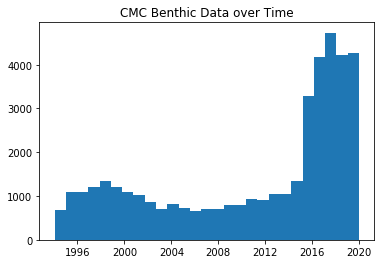

In [23]:
# change to datetime
allbenthic['Real_Date'] = pd.to_datetime(allbenthic['Date'])

# aggregate dates by month/year
allbenthic['month_year'] = allbenthic['Real_Date'].dt.to_period('M')

# sort by month/year
allbenthic = allbenthic.sort_values(by = 'month_year')

allbenthic_cmc = allbenthic[allbenthic['Database']=='CMC']
allbenthic_cbp = allbenthic[allbenthic['Database']=='CBP']

# plot
plt.hist(allbenthic_cmc['Real_Date'], bins = 27)
plt.title("CMC Benthic Data over Time");

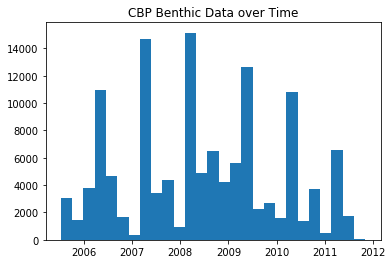

In [30]:
# plot
plt.hist(allbenthic_cbp['Real_Date'].dropna(), bins = 27)
plt.title("CBP Benthic Data over Time");